# Rogun HPP - Alignment DXF to Nodes in CSV

This procedure prepares alignment data from a CAD DXF and is intended to provide necessary input to the Hydropower Waterways Decision Support System (Waterways DSS), along with the Basemaps Setup module:
- alignments for feasibilty and siting analysis
- alignments for determing geolocation of project data and for visualizing this.

[Various means of using alignemnt data for hydropower and geotechnical analysis, which includes data analysis and visualization, have been reviewed:
1. export geometry from CAD (often Civil3d) using a suitable geospatial format and use python procedures for analysis: geojson(3d) would be ideal but is hot supported; LandXML is supported from Civil3d, but we found this to be complicated and fragile; DXF export is the time-proven fallback solution 
2. perform analysis inside of CAD (probably Civil3d), most probably as plug-in developed using C++ API: not a realistic scenario in most engineering consultancy offices
3. perform analysis from CAD ((probably Civil3d) using bindings to an external software development environment (pytprobably hon): solution does not yet exist and bindings to CAD/Civil3d are considered to have a steep learning curve.

The only practical choice at this time is 1.] (move this text to Notes)

The procedure described here is one of three procedrues foreseen for preparing alignment data for the Waterways DSS:
1. select alignment geometry from CAD (or e.g. Sketchup) and export as DXF, and process with grass and python for alignment definition
2. prepare alignment with surveying software (I am using Traverse PC), using alignment data from drawings and reports
3. digitize alignments from project layouts (e.g. as prepared by Basemap Setup) together with profile data, using QGIS, and export alignment as CSV (or alternatively query coordinates at tangent points along alignment and write into a CVS data file).

This procedure adresses in particular line data exported as DXF from Sketchup:
- "alignment" polyline data (main aim)
- wire mesh line data (just as a preliminary exploration).

The exported line data can in principle be either LINE or POLYLINE. My experience however is that Sketchup exports polylines as unordered LINE data, e.g. the exported polyline segments are not in topological order. It may be possible to group or weld lines to form a polyline (plug-in?) in Sketchup, but this would need to be robust in all edge cases. It seems easier to just allow for unordered line data as input to grass and to order the line data with grass.

Wire mesh data is processed with grass to LINESTRINGS, which remain as topologically unordered line segments. As the purpose of wire mesh data is only for visulaization of structures, unordered line segments will be suitable.

"Alignment" polyline data exported from Sketchup as unordered LINE data must be processed to produce an ordered sequence of vertices along the alignment polyline. This works explores processing the "alignment" polyline data in grass.

In [1]:
# ToDo
#   all data (e.g. file names) as variables
#   markdown titles
#   comments with explanations
#   this example use grass script, do again with pygrass defining class & methods (to go into API later)


## grass setup

In [2]:
# set up Python for GRASS GIS
import os
import sys
import subprocess
from IPython.display import Image

# set up GRASS GIS runtime environment
gisbase = subprocess.check_output(["grass", "--config", "path"]).strip()
os.environ['GISBASE'] = gisbase
os.environ['GRASS_FONT'] = 'sans'
os.environ['GRASS_OVERWRITE'] = '1'  #overwrite existing maps
sys.path.append(os.path.join(gisbase, "etc", "python"))

# set display modules to render into a file (named map.png by default)
os.environ['GRASS_RENDER_IMMEDIATE'] = 'cairo'
os.environ['GRASS_RENDER_FILE_READ'] = 'TRUE'
os.environ['GRASS_LEGEND_FILE'] = 'legend.txt'

# import GRASS GIS
import grass.script as gs
import grass.script.setup as gsetup
from grass.script import core as grass

# for pygrass
from grass.pygrass.modules.shortcuts import raster as r, vector as v, general as g, display as d

from subprocess import PIPE

# further setup for GRASS GIS 
gs.set_raise_on_error(True)
#gs.set_capture_stderr(True)  #might be Python 2 vs 3 issue (unsure if Python 3 required for this Notebook)

False

In [3]:
# https://grasswiki.osgeo.org/wiki/GRASS_Python_Scripting_Library
# GRASS Python Scripting Library
# How to retrieve error messages from read_command():

def read2_command(*args, **kwargs):                                                 #rename to e.g. read_grass
   kwargs['stdout'] = grass.PIPE
   kwargs['stderr'] = grass.PIPE
   ps = grass.start_command(*args, **kwargs)
   return ps.communicate()

In [4]:
# create a mapset (mapset does not already exist)
# should only do once (but will report error and exit if already exists)

# dir /home/kaelin_joseph/projects/RogunHEP/grassdata  should already exist
!grass -c EPSG:3857 /home/kaelin_joseph/projects/RogunHPP/grassdata/RogunHPP -e
# should use grass scipt                                                                             ToDo JK !!    

# define all parameters separately                                                                   ToDo JK !!
#EPSG:3857  #WGS84 Pseudo Mercator

Cleaning up temporary files...
Creating new GRASS GIS location/mapset...
ERROR: Failed to create new location. The location <RogunHPP> already exists.
Exiting...


In [5]:
# open mapset
rcfile = gsetup.init(gisbase, 
         "/home/kaelin_joseph/projects/RogunHPP/grassdata",
         "RogunHPP/", "PERMANENT")

In [6]:
# check grass env
print grass.gisenv()

{'MAPSET': 'PERMANENT', 'GISDBASE': '/home/kaelin_joseph/projects/RogunHPP/grassdata', 'LOCATION_NAME': 'RogunHPP/'}


In [7]:
# check projection info
read2_command('g.proj', flags = 'jf')

('+proj=merc +lat_ts=0.0 +lon_0=0.0 +x_0=0.0 +y_0=0 +k=1.0 +no_defs +a=6378137 +rf=298.257223563 +towgs84=0.000,0.000,0.000 +to_meter=1\n',
 '')

In [8]:
#check mapsets
grass.mapsets()

['PERMANENT']

In [9]:
# define required input data files for project
#alignment = '/home/kaelin_joseph/projects/RogunHPP/data/in/AlignmentDG4.dxf'
#alignment = '/home/kaelin_joseph/projects/RogunHPP/data/in/AlignmentDG3.dxf'
alignment = '/home/kaelin_joseph/projects/RogunHPP/data/in/AlignmentDG2.dxf'


# define required output data files for project
alignment_vect = 'alignment_dg4'
alignment_vect_ = 'alignment_dg4_'
alignment_vect_clean = 'alignment_dg4_cleaned'
alignment_points = 'alignment_dg4_points'
alignment_points_csv = '/home/kaelin_joseph/projects/RogunHPP/data/out/AlignmentDg4points.csv'
alignment_lines_csv = '/home/kaelin_joseph/projects/RogunHPP/data/out/AlignmentDg4lines.csv'
alignment_polyline_csv = '/home/kaelin_joseph/projects/RogunHPP/data/out/AlignmentDg4polyline.csv'
alignment_csv = '/home/kaelin_joseph/projects/RogunHPP/data/out/AlignmentDg2.csv'

## import DXF data

In [10]:
# read dxf data 
# read2_command("v.in.dxf", input='/home/kaelin_joseph/projects/RogunHPP/data/testing/Aignment_DG4.dxf', 
#              output='alignment_dg4', flags='e')[0]
read2_command("v.in.dxf", input=alignment, 
             output=alignment_vect, flags='e')[0]

# output in 'RogunHPP/PERMANENT/vector/topography2m_r5_reduced'

#read2_command("v.in.dxf")
# pattern for 'printing grass output nicely
#   decode must be applied to each member of tuple
#   [0] -> stdout
#   [1] -> stderr
#   above are according to doc, however it seems that [1] is where all output is                  ToDo JK:  ??

''

In [11]:
# set grass region from vector data bounds
read2_command('g.region', vector=alignment_vect)

('', '')

In [12]:
# check grass region
print(g.region(flags='p',stdout_=PIPE).outputs.stdout.decode())

projection: 99 (Mercator)
zone:       0
datum:      wgs84
ellipsoid:  wgs84
north:      23289.53753498
south:      23182.14074939
west:       27499.70895338
east:       27811.95122414
nsres:      1.98882936
ewres:      2.00155302
rows:       54
cols:       156
cells:      8424



In [13]:
# report of vector data imported from dxf
#  comment out individual reporting as desired

# report imported DXF layers
print(read2_command("v.info", map=alignment_vect, layer='-1', verbose=True)[0].decode()) 

# report entities in imported DXF layers
#   adjust range as desired
out = read2_command("v.db.select", map=alignment_vect)[0].splitlines()
for line in range(0,4):
    print(out[line])

# report categories in imported DXF layers
print('\n')
print(read2_command("v.category", input=alignment_vect, layer='-1', option='report', verbose=True)[0].decode()) 

# report coordinatesin imported DXF layers
#   adjust range as desired
out = read2_command("v.report", map=alignment_vect, layer='-1', option='coor', verbose=True)[0].splitlines()
for line in range(0,1):
    print(out[line])
    
# report on attributes stored in grass sqlite database
print('\n')
print(read2_command("v.db.connect", map=alignment_vect, flags='c', verbose=True)[0].decode()) 

 +----------------------------------------------------------------------------+
 | Name:            alignment_dg4                                             |
 | Mapset:          PERMANENT                                                 |
 | Location:        RogunHPP/                                                 |
 | Database:        /home/kaelin_joseph/projects/RogunHPP/grassdata           |
 | Title:           alignment_dg4                                             |
 | Map scale:       1:2400                                                    |
 | Name of creator: kaelin_joseph                                             |
 | Organization:    GRASS Development Team                                    |
 | Source date:                                                               |
 | Timestamp (first layer): none                                              |
 |----------------------------------------------------------------------------|
 | Map format:      native              

In [14]:
# view and check imported topography
!rm map.png                                                                                 #ToDo JK: pythonize
read2_command("d.vect", map=alignment_vect, color='green')

('', 'd.vect complete.\n')

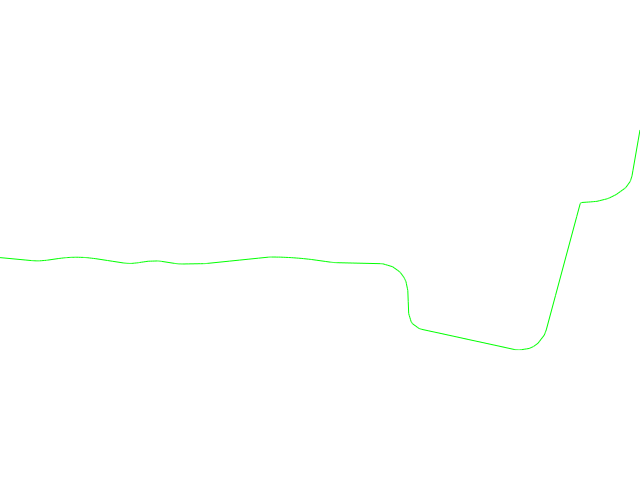

In [15]:
Image(filename="map.png")

## extract points (unordered) from imported DXF vector data

In [16]:
points_out = read2_command("v.to.points", input=alignment_vect, output=alignment_points) 
print(points_out[1].decode())

         overwritten
   2%   5%   8%  11%  14%  17%  20%  23%  26%  29%  32%  35%  38%  41%  44%  47%  50%  53%  56%  59%  62%  65%  68%  71%  74%  77%  80%  83%  86%  89%  92%  95%  98% 100%
Building topology for vector map <alignment_dg4_points@PERMANENT>...
Registering primitives...
616 primitives registered
616 vertices registered
Building areas...
   0%   2%   4%   6%   8%  10%  12%  14%  16%  18%  20%  22%  24%  26%  28%  30%  32%  34%  36%  38%  40%  42%  44%  46%  48%  50%  52%  54%  56%  58%  60%  62%  64%  66%  68%  70%  72%  74%  76%  78%  80%  82%  84%  86%  88%  90%  92%  94%

In [17]:
# view and check points topography
read2_command("d.vect", map=alignment_points, color='red')

('', 'd.vect complete.\n')

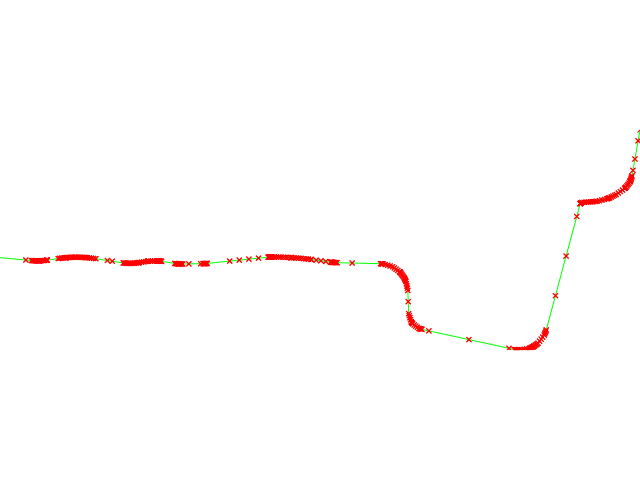

In [18]:
Image(filename="map.png")

In [19]:
#!v.out.ascii  --help

In [20]:
# write points extracted from imported DXF data to csv file

read2_command("v.out.ascii", input=alignment_points, type='point', separator=',',
              layer=-1, output=alignment_points_csv)

('', '')

In [21]:
#!head -5 /home/kaelin_joseph/projects/RogunHPP/data/out/AlignmentDg4points.csv
from __future__ import print_function
file = alignment_points_csv
with open(file, 'r') as f:
#   for line in f:
    for n in range(5):
        line = f.readline()
        print(line, end='')

27695.02141205,23219.95675863,988.55902888
27695.15756072,23219.81475837,988.54544973
27694.88526338,23220.09875889,988.57260802
27695.02141205,23219.95675863,988.55902888
27811.02431351,23284.21821834,972.35271119


## extract lines (unordered) from imported DXF vector data

In [22]:
# write lines from imported DXF data to csv file
read2_command("v.out.ascii", input=alignment_vect, type='line', format='wkt', 
              layer=-1, output=alignment_lines_csv)

('', '')

In [23]:
# open file and read some lines
file = alignment_lines_csv
with open(file, 'r') as f:
#   for line in f:
    for n in range(5):
        line = f.readline()
        print(line, end='')

LINESTRING(27695.02141205 23219.95675863 988.55902888, 27695.15756072 23219.81475837 988.54544973)
LINESTRING(27694.88526338 23220.09875889 988.57260802, 27695.02141205 23219.95675863 988.55902888)
LINESTRING(27811.02431351 23284.21821834 972.35271119, 27811.95122414 23289.53753498 971.88997648)
LINESTRING(27808.51788582 23269.83443400 972.77405525, 27809.47922055 23275.35130228 972.35271119)
LINESTRING(27808.05678481 23267.18828649 972.97615153, 27808.51788582 23269.83443400 972.77405525)


In [24]:
# open csv file and read
import csv
file = alignment_lines_csv
with open(file, 'r') as f:
  reader = csv.reader(f)  
  for line in reader:
    print(line)

['LINESTRING(27695.02141205 23219.95675863 988.55902888', ' 27695.15756072 23219.81475837 988.54544973)']
['LINESTRING(27694.88526338 23220.09875889 988.57260802', ' 27695.02141205 23219.95675863 988.55902888)']
['LINESTRING(27811.02431351 23284.21821834 972.35271119', ' 27811.95122414 23289.53753498 971.88997648)']
['LINESTRING(27808.51788582 23269.83443400 972.77405525', ' 27809.47922055 23275.35130228 972.35271119)']
['LINESTRING(27808.05678481 23267.18828649 972.97615153', ' 27808.51788582 23269.83443400 972.77405525)']
['LINESTRING(27807.88788544 23266.63106327 973.01967747', ' 27808.05678481 23267.18828649 972.97615153)']
['LINESTRING(27809.47922055 23275.35130228 972.35271119', ' 27811.02431351 23284.21821834 972.35271119)']
['LINESTRING(27785.69266564 23254.28590444 975.05095125', ' 27786.75652477 23254.35804564 974.97066134)']
['LINESTRING(27786.75652477 23254.35804564 974.97066134', ' 27787.82038389 23254.43018685 974.89037144)']
['LINESTRING(27787.82038389 23254.43018685 974

In [25]:
# parse and format csv data to format required for plotly 3d
#https://stackoverflow.com/questions/13597088/pythonic-way-to-read-file-line-by-line#https://stackoverflow.com/questions/16731461/parsing-a-wkt-file
#https://stackoverflow.com/questions/13597088/pythonic-way-to-read-file-line-by-lin#e

import pandas as pd

file = alignment_lines_csv
test=[]

with open(file, 'r') as f:
  for line in f:
    print(line)
    l1 = line.strip('LINESTRING')
    l2 = l1.strip('\n')
    l3 = l2.strip('(')
    l4 = l3.strip(')')
    l5 = l4.split(', ')
    for item in l5:
        coords = item.split(' ')
        li = []
        for c in coords:
            li.append(float(c))
        print(li) 
        test.append(li)


LINESTRING(27695.02141205 23219.95675863 988.55902888, 27695.15756072 23219.81475837 988.54544973)

[27695.02141205, 23219.95675863, 988.55902888]
[27695.15756072, 23219.81475837, 988.54544973]
LINESTRING(27694.88526338 23220.09875889 988.57260802, 27695.02141205 23219.95675863 988.55902888)

[27694.88526338, 23220.09875889, 988.57260802]
[27695.02141205, 23219.95675863, 988.55902888]
LINESTRING(27811.02431351 23284.21821834 972.35271119, 27811.95122414 23289.53753498 971.88997648)

[27811.02431351, 23284.21821834, 972.35271119]
[27811.95122414, 23289.53753498, 971.88997648]
LINESTRING(27808.51788582 23269.83443400 972.77405525, 27809.47922055 23275.35130228 972.35271119)

[27808.51788582, 23269.834434, 972.77405525]
[27809.47922055, 23275.35130228, 972.35271119]
LINESTRING(27808.05678481 23267.18828649 972.97615153, 27808.51788582 23269.83443400 972.77405525)

[27808.05678481, 23267.18828649, 972.97615153]
[27808.51788582, 23269.834434, 972.77405525]
LINESTRING(27807.88788544 23266.63

In [26]:
test

[[27695.02141205, 23219.95675863, 988.55902888],
 [27695.15756072, 23219.81475837, 988.54544973],
 [27694.88526338, 23220.09875889, 988.57260802],
 [27695.02141205, 23219.95675863, 988.55902888],
 [27811.02431351, 23284.21821834, 972.35271119],
 [27811.95122414, 23289.53753498, 971.88997648],
 [27808.51788582, 23269.834434, 972.77405525],
 [27809.47922055, 23275.35130228, 972.35271119],
 [27808.05678481, 23267.18828649, 972.97615153],
 [27808.51788582, 23269.834434, 972.77405525],
 [27807.88788544, 23266.63106327, 973.01967747],
 [27808.05678481, 23267.18828649, 972.97615153],
 [27809.47922055, 23275.35130228, 972.35271119],
 [27811.02431351, 23284.21821834, 972.35271119],
 [27785.69266564, 23254.28590444, 975.05095125],
 [27786.75652477, 23254.35804564, 974.97066134],
 [27786.75652477, 23254.35804564, 974.97066134],
 [27787.82038389, 23254.43018685, 974.89037144],
 [27787.82038389, 23254.43018685, 974.89037144],
 [27788.60124388, 23254.4997979, 974.83154246],
 [27788.60124388, 23254.4

In [27]:
# http://pbpython.com/pandas-list-dict.html
test_df = pd.DataFrame.from_records(test, columns=['Easting','Northing','Elevation'])
test_df.head(5)

,Easting,Northing,Elevation
0,27695.021412,23219.956759,988.559029
1,27695.157561,23219.814758,988.545450
2,27694.885263,23220.098759,988.572608
3,27695.021412,23219.956759,988.559029
4,27811.024314,23284.218218,972.352711


## order lines segments from imported DXF vector data

In [28]:
#try v.build.polylines to order lines in a way that connects like vertices 
#  e.g. a continuous polyline from unordered line segments

read2_command("v.build.polylines", input=alignment_vect, 
             output=alignment_vect_)[0]

''

In [29]:
# report of vector data output from v.build.polyline
#  comment out individual reporting as desired

# report imported DXF layers
print(read2_command("v.info", map=alignment_vect_, layer='-1', verbose=True)[0].decode()) 

# report entities in imported DXF layers
#   adjust range as desired
out = read2_command("v.db.select", map=alignment_vect_)[0].splitlines()
print(out)

# report categories in imported DXF layers
print('\n')
print(read2_command("v.category", input=alignment_vect_, layer='-1', option='report', verbose=True)[0].decode()) 

# report coordinatesin imported DXF layers
#   adjust range as desired
out = read2_command("v.report", map=alignment_vect_, layer='-1', option='coor', verbose=True)[0].splitlines()
print(out)
    
# report on attributes stored in grass sqlite database
print('\n')
print(read2_command("v.db.connect", map=alignment_vect_, flags='c', verbose=True)[0].decode()) 

 +----------------------------------------------------------------------------+
 | Name:            alignment_dg4_                                            |
 | Mapset:          PERMANENT                                                 |
 | Location:        RogunHPP/                                                 |
 | Database:        /home/kaelin_joseph/projects/RogunHPP/grassdata           |
 | Title:           alignment_dg4                                             |
 | Map scale:       1:2400                                                    |
 | Name of creator: kaelin_joseph                                             |
 | Organization:    GRASS Development Team                                    |
 | Source date:                                                               |
 | Timestamp (first layer): none                                              |
 |----------------------------------------------------------------------------|
 | Map format:      native              

In [30]:
# view and check topography from v.build.polylines
!rm map.png                                                                                 #ToDo JK: pythonize
read2_command("d.vect", map=alignment_vect_, color='green')

('', 'd.vect complete.\n')

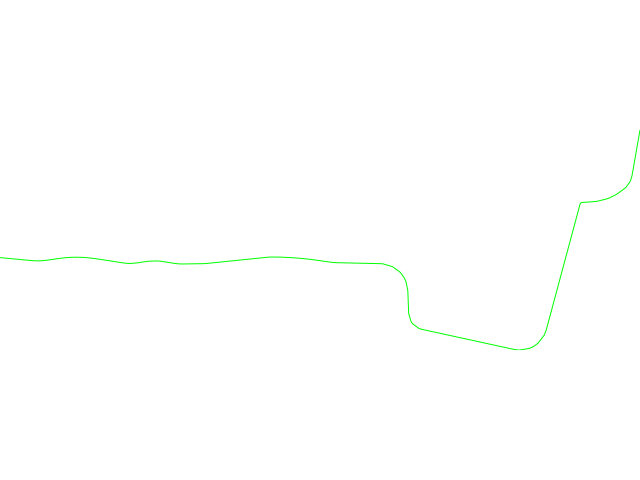

In [31]:
Image(filename="map.png")

In [32]:
# write polyline from v.build.polylines to csv file
read2_command("v.out.ascii", input=alignment_vect_, type='line', format='wkt', 
              layer=-1, output=alignment_polyline_csv)

('', '')

In [33]:
file = alignment_polyline_csv
with open(file, 'r') as f:
#   for line in f:
    for n in range(5):
        line = f.readline()
        print(line, end='')

LINESTRING(27499.70895338 23227.25632318 1001.07997648, 27512.33534060 23226.05955772 1000.63571570, 27515.04251031 23225.80296435 1000.54046364, 27515.61306967 23225.76915020 1000.52049151, 27516.18362903 23225.73533606 1000.50051938, 27516.75418840 23225.70152191 1000.48054725, 27517.32474776 23225.66770777 1000.46057512, 27517.72615544 23225.66806957 1000.44655014, 27518.12756311 23225.66843137 1000.43252515, 27518.52897079 23225.66879317 1000.41850017, 27518.93037846 23225.66915497 1000.40447519, 27518.96255871 23225.67004600 1000.40335051, 27518.99473895 23225.67093702 1000.40222583, 27519.02691920 23225.67182805 1000.40110116, 27519.05909945 23225.67271907 1000.39997648, 27519.87576787 23225.73842967 1000.35070188, 27520.69243630 23225.80414026 1000.30142728, 27521.50910473 23225.86985086 1000.25215268, 27522.32577316 23225.93556145 1000.20287808, 27522.44589026 23225.95229234 1000.19558733, 27522.56600737 23225.96902323 1000.18829658, 27522.68612447 23225.98575412 1000.18100584,

In [34]:
# parse and format csv data to format required for plotly 3d
#https://stackoverflow.com/questions/13597088/pythonic-way-to-read-file-line-by-line#https://stackoverflow.com/questions/16731461/parsing-a-wkt-file
#https://stackoverflow.com/questions/13597088/pythonic-way-to-read-file-line-by-lin#e

# comment in/out LINESTRING/LINEARRING based on polyline entity

import pandas as pd

test=[]

with open(file, 'r') as f:
  for line in f:
    #print(line)
    l1 = line.strip('LINESTRING')
    #l1 = line.strip('LINEARRING')
    l2 = l1.strip('\n')
    l3 = l2.strip('(')
    l4 = l3.strip(')')
    l5 = l4.split(', ')
    for item in l5:
        coords = item.split(' ')
        li = []
        for c in coords:
            li.append(float(c))
        print(li) 
        test.append(li)

[27499.70895338, 23227.25632318, 1001.07997648]
[27512.3353406, 23226.05955772, 1000.6357157]
[27515.04251031, 23225.80296435, 1000.54046364]
[27515.61306967, 23225.7691502, 1000.52049151]
[27516.18362903, 23225.73533606, 1000.50051938]
[27516.7541884, 23225.70152191, 1000.48054725]
[27517.32474776, 23225.66770777, 1000.46057512]
[27517.72615544, 23225.66806957, 1000.44655014]
[27518.12756311, 23225.66843137, 1000.43252515]
[27518.52897079, 23225.66879317, 1000.41850017]
[27518.93037846, 23225.66915497, 1000.40447519]
[27518.96255871, 23225.670046, 1000.40335051]
[27518.99473895, 23225.67093702, 1000.40222583]
[27519.0269192, 23225.67182805, 1000.40110116]
[27519.05909945, 23225.67271907, 1000.39997648]
[27519.87576787, 23225.73842967, 1000.35070188]
[27520.6924363, 23225.80414026, 1000.30142728]
[27521.50910473, 23225.86985086, 1000.25215268]
[27522.32577316, 23225.93556145, 1000.20287808]
[27522.44589026, 23225.95229234, 1000.19558733]
[27522.56600737, 23225.96902323, 1000.18829658]


In [35]:
# http://pbpython.com/pandas-list-dict.html
test_df = pd.DataFrame.from_records(test, columns=['Easting','Northing','Elevation'])
#test_df.head(5)
test_df

,Easting,Northing,Elevation
0,27499.708953,23227.256323,1001.079976
1,27512.335341,23226.059558,1000.635716
2,27515.042510,23225.802964,1000.540464
3,27515.613070,23225.769150,1000.520492
4,27516.183629,23225.735336,1000.500519
5,27516.754188,23225.701522,1000.480547
6,27517.324748,23225.667708,1000.460575
7,27517.726155,23225.668070,1000.446550
8,27518.127563,23225.668431,1000.432525
9,27518.528971,23225.668793,1000.418500


In [36]:
test_df.to_csv(alignment_csv)


In [37]:
file = alignment_csv
with open(file, 'r') as f:
#   for line in f:
    for n in range(5):
        line = f.readline()
        print(line, end='')

,Easting,Northing,Elevation
0,27499.70895338,23227.25632318,1001.07997648
1,27512.3353406,23226.05955772,1000.6357157
2,27515.04251031,23225.80296435,1000.54046364
3,27515.61306967,23225.7691502,1000.52049151


## additional cleaning and simplification of line segments

In [38]:
# cleaning of imported vector data required if required
#  does not seem to rm unneeded points (e.g. intermediate points along straight segments)

# https://grass.osgeo.org/grass74/manuals/v.clean.html
# https://grasswiki.osgeo.org/wiki/Vector_topology_cleaning

print(read2_command("v.clean", input=alignment_vect, 
                    tool='prune,break,snap,rmdangle,rmdupl,rmbridge,chbridge,bpol', threshold=0.001, 
                    output=alignment_vect_clean)[1].decode()) 

--------------------------------------------------
Tool: Threshold
Prune: 0.001
Break: 0
Snap vertices: 0
Remove dangles: 0
Remove duplicates: 0
Remove bridges: 0
Change type of boundary bridges: 0
Break polygons: 0
--------------------------------------------------
         overwritten
Copying features...
   2%   5%   8%  11%  14%  17%  20%  23%  26%  29%  32%  35%  38%  41%  44%  47%  50%  53%  56%  59%  62%  65%  68%  71%  74%  77%  80%  83%  86%  89%  92%  95%  98% 100%
Rebuilding parts of topology...
Building topology for vector map <alignment_dg4_cleaned@PERMANENT>...
Registering primitives...
308 primitives registered
616 vertices registered
Building areas...
   0%   2%   4%   6%   8%  10%  12%  14%  16%  18%  20%  22%  24%  26%  28%  30%

In [39]:
# v.build.polylines to order lines in a way that connects like vertices 
#  e.g. a continuous polyline from unordered line segments

read2_command("v.build.polylines", input=alignment_vect_clean, 
             output=alignment_vect_)[0]

''

In [40]:
# cleaning of polyline if required
# simplify lines (rm unneeded points, e.g. intermediate points along straight segments)
# https://grasswiki.osgeo.org/wiki/V.generalize_tutorial#Smoothing
# https://en.wikipedia.org/wiki/Ramer%E2%80%93Douglas%E2%80%93Peucker_algorithm
# https://grass.osgeo.org/grass74/manuals/v.generalize.html

print(read2_command("v.generalize", input=alignment_vect_, 
                    method='douglas_reduction', threshold=0.001, 
                    output=alignment_vect_clean)[1].decode()) 

         overwritten
Copying features...
 100%
Building topology for vector map <alignment_dg4_cleaned@PERMANENT>...
Registering primitives...
One primitive registered
309 vertices registered
Building areas...
   0% 100%
0 areas built
0 isles built
Attaching islands...
Attaching centroids...
 100%
Number of nodes: 2
Number of primitives: 1
Number of points: 0
Number of lines: 1
Number of boundaries: 0
Number of centroids: 0
Number of areas: 0
Number of isles: 0
-----------------------------------------------------
Generalization (douglas_reduction)...
Using threshold: 0.001 meters
 100%
-----------------------------------------------------
Building topology for vector map <alignment_dg4_cleaned@PERMANENT>...
Registering primitives...
One primitive registered
85 vertices registered
Building areas...
   0% 100%
0 areas built
0 isles built
Attaching islands...
Attaching centroids...
 100%
Number of nodes: 2
Number of primitives: 1
Number of points: 

In [41]:
# report of vector data output from v.build.polyline
#  comment out individual reporting as desired

# report imported DXF layers
print(read2_command("v.info", map=alignment_vect_clean, layer='-1', verbose=True)[0].decode()) 

# report entities in imported DXF layers
#   adjust range as desired
out = read2_command("v.db.select", map=alignment_vect_clean)[0].splitlines()
print(out)

# report categories in imported DXF layers
print('\n')
print(read2_command("v.category", input=alignment_vect_clean, layer='-1', option='report', verbose=True)[0].decode()) 

# report coordinatesin imported DXF layers
#   adjust range as desired
out = read2_command("v.report", map=alignment_vect_clean, layer='-1', option='coor', verbose=True)[0].splitlines()
print(out)
    
# report on attributes stored in grass sqlite database
print('\n')
print(read2_command("v.db.connect", map=alignment_vect_clean, flags='c', verbose=True)[0].decode()) 

 +----------------------------------------------------------------------------+
 | Name:            alignment_dg4_cleaned                                     |
 | Mapset:          PERMANENT                                                 |
 | Location:        RogunHPP/                                                 |
 | Database:        /home/kaelin_joseph/projects/RogunHPP/grassdata           |
 | Title:           alignment_dg4                                             |
 | Map scale:       1:2400                                                    |
 | Name of creator: kaelin_joseph                                             |
 | Organization:    GRASS Development Team                                    |
 | Source date:                                                               |
 | Timestamp (first layer): none                                              |
 |----------------------------------------------------------------------------|
 | Map format:      native              

In [42]:
# view and check topography from v.build.polylines
!rm map.png                                                                                 #ToDo JK: pythonize
read2_command("d.vect", map=alignment_vect_clean, color='green')

('', 'd.vect complete.\n')

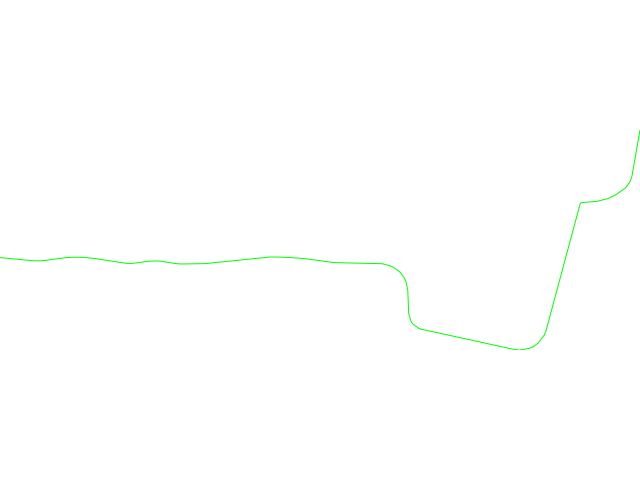

In [43]:
Image(filename="map.png")

In [44]:
# write polyline from v.build.polylines to csv file
read2_command("v.out.ascii", input=alignment_vect_clean, type='line', format='wkt', 
              layer=-1, output=alignment_polyline_csv)

('', '')

In [45]:
file = alignment_polyline_csv
with open(file, 'r') as f:
#   for line in f:
    for n in range(5):
        line = f.readline()
        print(line, end='')

LINESTRING(27499.70895338 23227.25632318 1001.07997648, 27515.04251031 23225.80296435 1000.54046364, 27517.32474776 23225.66770777 1000.46057512, 27518.93037846 23225.66915497 1000.40447519, 27519.05909945 23225.67271907 1000.39997648, 27522.32577316 23225.93556145 1000.20287808, 27522.80624157 23226.00248501 1000.17371509, 27528.11768861 23226.78290265 999.85013166, 27531.35359024 23227.17123652 999.65339431, 27532.23279450 23227.24688004 999.60013067, 27534.60549880 23227.38792358 999.45665695, 27537.22088841 23227.43724444 999.29875697, 27540.54707919 23227.33949226 999.09788318, 27542.20802250 23227.22320485 998.99738326, 27546.45636746 23226.71898014 998.73910941, 27554.47680114 23225.48334820 998.24997648, 27559.82096988 23224.66002295 997.88858142, 27562.00943016 23224.43227770 997.74202534, 27563.77758249 23224.40571939 997.62425584, 27567.00973798 23224.72051385 997.40784696, 27567.71699995 23224.85342887 997.35993025, 27571.94294632 23225.47410648 997.07366857, 27572.01135880

In [46]:
# parse and format csv data to format required for plotly 3d
#https://stackoverflow.com/questions/13597088/pythonic-way-to-read-file-line-by-line#https://stackoverflow.com/questions/16731461/parsing-a-wkt-file
#https://stackoverflow.com/questions/13597088/pythonic-way-to-read-file-line-by-lin#e

# comment in/out LINESTRING/LINEARRING based on polyline entity

import pandas as pd

test=[]

with open(file, 'r') as f:
  for line in f:
    #print(line)
    l1 = line.strip('LINESTRING')
    #l1 = line.strip('LINEARRING')
    l2 = l1.strip('\n')
    l3 = l2.strip('(')
    l4 = l3.strip(')')
    l5 = l4.split(', ')
    for item in l5:
        coords = item.split(' ')
        li = []
        for c in coords:
            li.append(float(c))
        print(li) 
        test.append(li)

[27499.70895338, 23227.25632318, 1001.07997648]
[27515.04251031, 23225.80296435, 1000.54046364]
[27517.32474776, 23225.66770777, 1000.46057512]
[27518.93037846, 23225.66915497, 1000.40447519]
[27519.05909945, 23225.67271907, 1000.39997648]
[27522.32577316, 23225.93556145, 1000.20287808]
[27522.80624157, 23226.00248501, 1000.17371509]
[27528.11768861, 23226.78290265, 999.85013166]
[27531.35359024, 23227.17123652, 999.65339431]
[27532.2327945, 23227.24688004, 999.60013067]
[27534.6054988, 23227.38792358, 999.45665695]
[27537.22088841, 23227.43724444, 999.29875697]
[27540.54707919, 23227.33949226, 999.09788318]
[27542.2080225, 23227.22320485, 998.99738326]
[27546.45636746, 23226.71898014, 998.73910941]
[27554.47680114, 23225.4833482, 998.24997648]
[27559.82096988, 23224.66002295, 997.88858142]
[27562.00943016, 23224.4322777, 997.74202534]
[27563.77758249, 23224.40571939, 997.62425584]
[27567.00973798, 23224.72051385, 997.40784696]
[27567.71699995, 23224.85342887, 997.35993025]
[27571.9429

In [47]:
# http://pbpython.com/pandas-list-dict.html
test_df = pd.DataFrame.from_records(test, columns=['Easting','Northing','Elevation'])
#test_df.head(5)
test_df

,Easting,Northing,Elevation
0,27499.708953,23227.256323,1001.079976
1,27515.042510,23225.802964,1000.540464
2,27517.324748,23225.667708,1000.460575
3,27518.930378,23225.669155,1000.404475
4,27519.059099,23225.672719,1000.399976
5,27522.325773,23225.935561,1000.202878
6,27522.806242,23226.002485,1000.173715
7,27528.117689,23226.782903,999.850132
8,27531.353590,23227.171237,999.653394
9,27532.232794,23227.246880,999.600131


In [48]:
test_df.to_csv(alignment_csv)


In [49]:
file = alignment_csv
with open(file, 'r') as f:
#   for line in f:
    for n in range(5):
        line = f.readline()
        print(line, end='')

,Easting,Northing,Elevation
0,27499.70895338,23227.25632318,1001.07997648
1,27515.04251031,23225.80296435,1000.54046364
2,27517.32474776,23225.66770777,1000.46057512
3,27518.93037846,23225.66915497,1000.40447519


## reverse ordered line segments

In [50]:
# aim is to be able to station in an opposite direction